# Оглавление:

### 1. Первичная работа с данными
         - Загрузка данных, пакетов
         - Проверка на всякие ошибки
         - Данные о днях и странах в новые переменные
         - В данных о транзакциях приведем переменную from_page в фиктивные переменные
         - Окончательные датасеты
  
### 2. Проверка сплит-системы 
         - Первый взгляд на описательную статистику
         - А/А тест
         - А/А тесты раздельно для тех, у кого есть данные о днях, и для тех, у кого таких данных нет

### 3. А/В тест
         - Для выручки и монет
         - Промежуточный вывод

### 4. Propensity Score Matching
         - Описание алгоритма
         - Logit propensity scores
         - Matching и выводы об А/В тесте

### 5. Регрессионный анализ влияния отдельных переменных
         - Неудачная попытка поборость гетероскедастичность
### 6. Общие выводы

=================================================================================================================

### 1. Первичная работа с данными

### Загрузка данных, пакетов

Подгрузим нужные пакеты

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import datetime as dt
import pycountry
import matplotlib.pyplot as plt
import pycountry_convert as pc
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn import cluster
import seaborn as sns
%matplotlib inline

Подгрузим наши данные

In [2]:
import requests
from urllib.parse import urlencode
import io

urls = ['ya_J0W53q_P-Pg', 'e8JOiJhNdc1fqA', 'E6MshHtdPdtMBQ', 'iTLiuxIWRc42Hg', 'JykTu7f00oCHpw', 'NsvacYvGbqo_dQ']
data_names = ['users_test',
              'users_control_1',
              'users_control_2',
              'transactions_test', 
              'transactions_control_1', 
              'transactions_control_2']

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
for i in range(len(urls)):
    public_key = 'https://disk.yandex.ru/d/' + urls[i]
    final_url = base_url + urlencode(dict(public_key = public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    download = requests.get(download_url).content
    locals()[data_names[i]] = pd.read_csv(io.StringIO(download.decode('utf-8')), sep = ';')

### Проверка на всякие ошибки

Посмотрим, есть ли повторяющиеся клиенты в контрольных группах и в тестовой. Если повторов нет, то можно просто объединить таблички и не множить сущности.

In [3]:
temp_v1 = sum([x in users_control_2.uid.unique() for x in users_control_1.uid.unique()])
temp_v2 = sum([x in users_test.uid.unique() for x in users_control_1.uid.unique()])
temp_v3 = sum([x in users_test.uid.unique() for x in users_control_2.uid.unique()])
f'В контрольной группе 1 и 2 {temp_v1} повторяющихся пользователей, аналогично {temp_v2} и {temp_v3} пересечений между тестовой и контрольными группами 1 и 2'

'В контрольной группе 1 и 2 0 повторяющихся пользователей, аналогично 0 и 0 пересечений между тестовой и контрольными группами 1 и 2'

In [4]:
users = pd.concat([users_test, users_control_1, users_control_2]).reset_index(drop = True)

In [5]:
uid_test = users_test.uid.to_list()
uid_control_1 = users_control_1.uid.to_list()
uid_control_2 = users_control_2.uid.to_list()

In [6]:
users['control_1'] = [1 if x in uid_control_1 else 0 for x in users.uid.to_list()]
users['control_2'] = [1 if x in uid_control_2 else 0 for x in users.uid.to_list()]

### Данные о днях и странах в новые переменные 

Теперь посмотрим, что у нас есть в списке стран. Странновое различие не такое большое, большинство клиентов находятся в не самом длинном списке стран. Так как хочется перевести переменную "страна" в фиктивные переменные, сократим список стран так, чтобы для 95% пользователей учитывалась страна. Для остальных мы запишем страну как "другую". Чтобы дополнительно учитывать некоторые культурные особенности добавим переменную континент.

In [7]:
def country_to_continent(country_name):
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name

In [8]:
def get_country_list(series_of_countries, top):
    #преведем названия стран к нужному формату
    series_of_countries = list(map(lambda x: x.replace('United Kingdom (Great Britain)', 'United Kingdom'), 
                                   series_of_countries.to_list()))
    iso_countries_names = {keys: pycountry.countries.search_fuzzy(keys)[0].name 
                           for keys in np.unique(np.array(series_of_countries))}
    result1 = list(map(lambda x: iso_countries_names[x], series_of_countries))
    #добавим континент
    continents_names = {keys: country_to_continent(keys) 
                        for keys in list(iso_countries_names.values())}
    result2 = list(map(lambda x: continents_names[x], result1))
    #теперь теперь объединеним непопулярные странны
    temp = pd.Series(result1).value_counts()
    i = 0
    y = 0
    while y < sum(temp.values) * top:
        y = y + temp.values[i]
        i = i + 1
    popular_countries = temp.index[0:(i+1)]
    replaced_names = {keys: keys if keys in popular_countries else 'the_other' for keys in iso_countries_names.values()}
    result1 = list(map(lambda x: replaced_names[x], result1))
    return np.matrix([result1, result2])

In [9]:
m = get_country_list(users.country, 0.95)
users['country'] = m[0].tolist()[0]
users['continent'] = m[1].tolist()[0]

Теперь разбиремся с данными о днях. Посмотрим, существует ли "нулевой" день. Если не существует, то заменим нулями все пропуски.

In [10]:
try:
    users.visit_days.value_counts().index.to_list().index('0')
except ValueError:
    print('Здесь нет нулей, только пустые значения \nЗаполним пустые значение нулями \nВот новая таблица с значениями')
    users.visit_days = users.visit_days.fillna('0')
    print(users.visit_days.value_counts())
except:
    print('что-то не то другое')      

Здесь нет нулей, только пустые значения 
Заполним пустые значение нулями 
Вот новая таблица с значениями
0                                                                  4018
1                                                                  1704
1,2                                                                 767
1,2,3                                                               436
1,2,3,4                                                             340
                                                                   ... 
1,2,3,5,6,7,8,10,11,12,13,14,15                                       1
2,3,4,5,6,7,8,9,10,11,13,14,15,16,18,19,20                            1
1,2,3,4,5,8,9,10,13,14,15                                             1
1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,18,19,20,21,22,23,25,27,28       1
2,3,5,7,9,10,12,14,15                                                 1
Name: visit_days, Length: 2133, dtype: int64


Теперь приведем данные о днях в три переменные: самый дальний день авторизации в приложении после регистрации, количество активных недель (считается неделя активной, если заходил больше в половине дней в неделе) и количество дней, когда пользователь заходил в приложение. В целом, этого должно быть достаточно, что передать большую часть информации заложенную в списке дней.

In [11]:
users['visit_days_max'] = list(map(lambda x: int(x.split(',')[-1]) if len(x) > 1 else int(x), users.visit_days.to_list()))
users['active_weeks'] = list(map(lambda x: np.sum([pd.Series([y // 7 for y in [int(x) for x in x.split(',')]]) \
                                                   .value_counts().values > 4]),
                                                    users.visit_days))
users['n_visit_days'] = list(map(lambda x:  np.count_nonzero([int(x) for x in x.split(',')]), users.visit_days))

Заполним остальные пропуски.

In [12]:
users.coins = users.coins.fillna(0)
users.was_premium = users.was_premium.fillna(0).astype(int)
users.is_premium = users.is_premium.fillna(0).astype(int)

In [13]:
f'Вот такое количество пропусков осталось: {users.isna().sum().sum()}'

'Вот такое количество пропусков осталось: 0'

Преведем страны и континенты в фиктивные переменные.

In [14]:
def get_dummies(columns_list, pandas_table):
    for i in columns_list:
        column = pandas_table[i]
        l = column.value_counts().index
        fe = l[0]
        l = l[1:]
        for j in range(len(l)):
            name_of_the_column = 'is_' + l[j].lower().replace(' ', '_')
            pandas_table[name_of_the_column] = list(map(lambda x: 1 if x == l[j] else 0, column))
        print(f'Столбец {i.upper()} был превращен в {len(l)} столбцов. Без фиктивной переменной осталось самое частое значение: {fe}')
    return pandas_table     

In [15]:
df = get_dummies(['continent', 'country'], users)

Столбец CONTINENT был превращен в 5 столбцов. Без фиктивной переменной осталось самое частое значение: North America
Столбец COUNTRY был превращен в 14 столбцов. Без фиктивной переменной осталось самое частое значение: United States


### В данных о транзакциях приведем переменную from_page в фиктивные переменные

Данные о транзакциях приведем в такое же состояние: удалим пустые значения, положим в одну таблицу, добавим фиктивные переменные относятся ли данное наблюдение к контрольной группе.

In [16]:
transactions_control_2 = transactions_control_2.dropna(how = 'all')
transactions_control_1 = transactions_control_1.dropna(how = 'any') # почему-то только так работает, а не как должно. Лишнего не удалено тем не менее

In [17]:
transactions = pd.concat([transactions_test, transactions_control_1, transactions_control_2]).reset_index(drop = True)
uid_test_t = transactions_test.uid.to_list()
uid_control_1_t = transactions_control_1.uid.to_list()
uid_control_2_t = transactions_control_2.uid.to_list()
transactions['control_1'] = [1 if x in uid_control_1_t else 0 for x in transactions.uid.to_list()]
transactions['control_2'] = [1 if x in uid_control_2_t else 0 for x in transactions.uid.to_list()]

Теперь посмотрим на время: по не совсем понятной причине время регистрации после времени транзакции. Возможно, просто перепутанны. Не думаю, что время оплаты и регистрации имеют значение без друг друга: куда интереснее смотреть на разницу между ними. То есть сколько времени прошло, пока те, кто таки купили премиум, пользовались бесплатной версией.

In [18]:
transactions['difference_reg_paid'] = pd.to_datetime(transactions.paid_at) - pd.to_datetime(transactions.joined_at)
transactions['difference_reg_paid'] = [x.days for x in transactions['difference_reg_paid'].to_list()]

Поскольку наблюдейний не много, давайте сократим количество количество версий from_page, оставим самые популярные: те, что описывают 90% всех случаев.

In [19]:
temp = transactions.from_page.value_counts()
i = 0
y = 0
while y < sum(temp.values) * 0.9:
    y = y + temp.values[i]
    i = i + 1
from_page_list = temp.index[0:(i+1)]
replaced_names = {keys: keys if keys in from_page_list else 'the_other_page' for keys in temp.index}
transactions.from_page = list(map(lambda x: replaced_names[x], transactions.from_page))

В новую таблицу положим данные уже с фиктивными переменными.

In [20]:
df_t = get_dummies(['from_page', 'product_type'], transactions)

Столбец FROM_PAGE был превращен в 12 столбцов. Без фиктивной переменной осталось самое частое значение: empty_likes
Столбец PRODUCT_TYPE был превращен в 3 столбцов. Без фиктивной переменной осталось самое частое значение: coins


### Окончательные датасеты

Уберем из таблицы все нечисловые значения.

In [21]:
df = df.drop(['uid', 'country', 'visit_days', 'continent'], axis=1)

In [22]:
df

,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,...,is_chile,is_united_arab_emirates,is_germany,is_united_kingdom,is_canada,is_the_other,is_israel,is_portugal,is_belgium,is_australia
0,27,685,0.0,1,24,30,89,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,27,0,0.0,1,24,30,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,45,44,0.0,1,42,48,68,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,32,0,0.0,1,29,35,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,27,1000,0.0,1,24,30,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12907,63,242,0.0,1,50,66,33,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12908,35,500,0.0,1,24,45,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12909,41,333,0.0,1,38,44,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12910,48,210,0.0,1,45,51,19,0,0,0,...,0,0,0,1,0,0,0,0,0,0


Уберем ненужные все нечисловые значения и из таблицы о транзакциях.

In [23]:
df_t = df_t.drop(['uid', 'country', 'joined_at', 'paid_at', 'payment_id', 'from_page', 'product_type'], axis = 1)

После того, как данные причесанны можно посмотреть, а насколько хорошо работает разделение. 
Посмотрим описательную статистику.

### 2. Проверка сплит-системы

### Первый взгляд на описательную статистику

In [24]:
descr1 = df.query('control_1 == 1').describe()
descr2 = df.query('control_2 == 1').describe()
pd.DataFrame({'mean1': descr1.loc['mean'], 'mean2':descr2.loc['mean'],
              'std1': descr1.loc['std'], 'std2': descr2.loc['std'],
              'diff': abs((descr1.loc['mean']-descr2.loc['mean'])*100/descr1.loc['mean'])}) \
                .sort_values('diff', ascending = False)

,mean1,mean2,std1,std2,diff
control_2,0.000000,1.000000,0.000000,0.000000,inf
control_1,1.000000,0.000000,0.000000,0.000000,100.000000
coins,24.136866,0.259615,1518.279250,4.724639,98.924403
is_israel,0.025115,0.018293,0.156493,0.134023,27.164914
total_revenue,594.761982,450.384146,7987.922925,2859.242228,24.274893
is_belgium,0.024885,0.021107,0.155792,0.143758,15.181363
is_italy,0.077880,0.068715,0.268014,0.252998,11.768542
is_germany,0.043318,0.047373,0.203595,0.212461,9.361902
is_spain,0.078802,0.072702,0.269460,0.259677,7.741132
is_asia,0.077189,0.071529,0.266922,0.257737,7.332475


Вообще, не так уж и плохо как могло быть: данные явно смещены по списку стран в разных контрольных группах. Радует, что привлекалетельность, пол и возраст (одни из ключевых характеристик аудитории) не различается по кольтрольным группам.
Нас все таки интересует, насколько плохо все с выручкой и внутренней валютой.

### А/А тест

In [25]:
def a_a_boot(
    pandas_table,
    rule0,
    rule1,
    boot_simulations = 1000,
    a_a_sample = 1000
):
    list_of_variables = pandas_table.columns
    pv_dict = {key:0 for key in list_of_variables}
    for c in list_of_variables:
        
        v0 = df.query(rule0)[c] #should be numpy array
        v1 = df.query(rule1)[c]
        #list with results
        res = []
        if pandas_table[c].value_counts().index.size > 5: # t-test
            for i in range(boot_simulations):
                
                b0 = np.random.choice(v0, a_a_sample, replace = False)
                b1 = np.random.choice(v1, a_a_sample, replace = False)
                
                res.append(ss.ttest_ind(b0, b1).pvalue)
        else: #chisquared
            
            v = pandas_table[c].value_counts()
            v = {v.index[keys]: 0 for keys in range(v.index.size)}
            
            for i in range(boot_simulations):
                
                b0 = pd.Series(np.random.choice(v0, a_a_sample, replace = False)).value_counts()
                b0 = {b0.index[keys]: b0.values[keys]  for keys in range(b0.index.size)}
        
                b1 = pd.Series(np.random.choice(v1, a_a_sample, replace = False)).value_counts()
                b1 = {b1.index[keys]: b1.values[keys]  for keys in range(b1.index.size)}
                
                temp0 = v.copy()
                temp1 = v.copy()
                for g in b0.keys():
                    temp0[g] = b0[g]
                for g in b1.keys():
                    temp1[g] = b1[g]
                if 0 in temp1.values():
                    x = 0
                else:
                    x = ss.chisquare(f_obs = [*temp0.values()], f_exp = [temp1[j] for j in temp1.keys()]).pvalue
        
                res.append(x)
        pv_dict[c] = res
    return pv_dict

In [26]:
np.random.seed(1)
pv_t = pd.DataFrame(a_a_boot(df, 'control_1 == 1', 'control_2 == 1'))
pv_t = pv_t.drop(['control_1', 'control_2'], axis = 1)

In [27]:
keys = []
for i in range(8):
    for j in range(4):
        keys.append(str(i)+str(j))
interat = {i: keys.index(i) for i in keys}

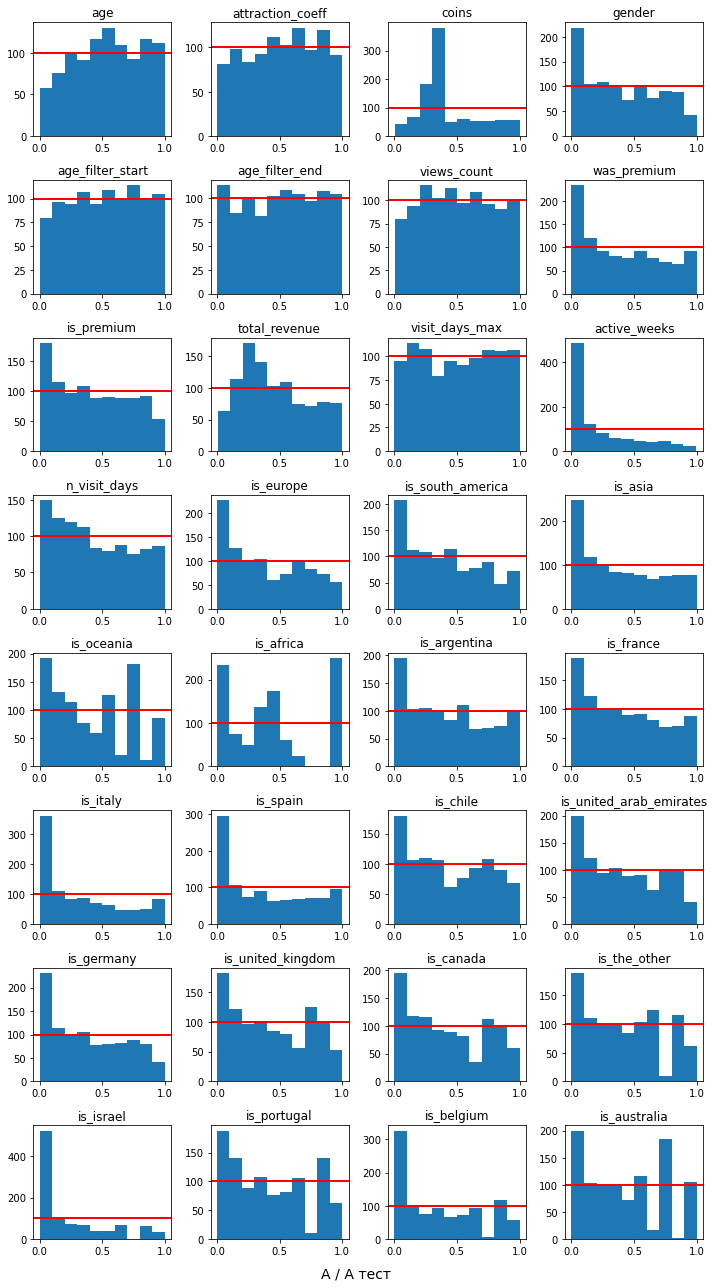

In [28]:
figure, axis = plt.subplots(8, 4, figsize=(10, 18))
  
for i in range(8):
    for j in range(4):
        x = interat[str(i)+str(j)]
        axis[i, j].hist(pv_t[pv_t.columns[x]], bins = 10)
        axis[i, j].axline((0, 100), (1, 100), linewidth=2, color='r')
        axis[i, j].set_title(pv_t.columns[x])

figure.suptitle('А / А тест', y = 0,
             fontsize=14)
figure.tight_layout()
plt.show()

Видно, что подозрения по поводу одинаковости/неодинакости распределения признаков подтвердились.

Возможно, можно как-то отфильтровать данные, удалив пользователей со странной статистикой.

### А/А тесты раздельно для тех, у кого есть данные о днях, и для тех, у кого таких данных нет

In [29]:
df.query('n_visit_days == 0').describe()

,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,...,is_chile,is_united_arab_emirates,is_germany,is_united_kingdom,is_canada,is_the_other,is_israel,is_portugal,is_belgium,is_australia
count,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,...,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000
mean,31.229467,264.603285,0.069686,0.949726,26.716277,37.450224,15.281483,0.055251,0.016924,127.829019,...,0.061971,0.049776,0.039323,0.033350,0.028123,0.012444,0.017173,0.020657,0.020906,0.014684
std,9.972859,338.312741,3.094579,0.218537,9.179408,15.137940,91.478407,0.228499,0.129002,1208.836749,...,0.241133,0.217509,0.194387,0.179571,0.165346,0.110870,0.129931,0.142251,0.143087,0.120299
min,16.000000,0.000000,0.000000,0.000000,13.000000,19.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,0.000000,0.000000,1.000000,19.000000,27.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,29.000000,62.000000,0.000000,1.000000,24.500000,34.000000,3.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,500.000000,0.000000,1.000000,32.000000,43.000000,9.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,99.000000,1000.000000,190.000000,1.000000,96.000000,102.000000,4770.000000,1.000000,1.000000,18304.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
df_visit_days_0 = df.query('n_visit_days == 0').drop(['active_weeks', 'visit_days_max', 'n_visit_days'], axis = 1)
df_visit_days_1 = df.query('n_visit_days != 0')

In [31]:
np.random.seed(2)
pv_t = pd.DataFrame(a_a_boot(df_visit_days_0, 'control_1 == 1', 'control_2 == 1'))
pv_t = pv_t.drop(['control_1', 'control_2', 'coins'], axis = 1)

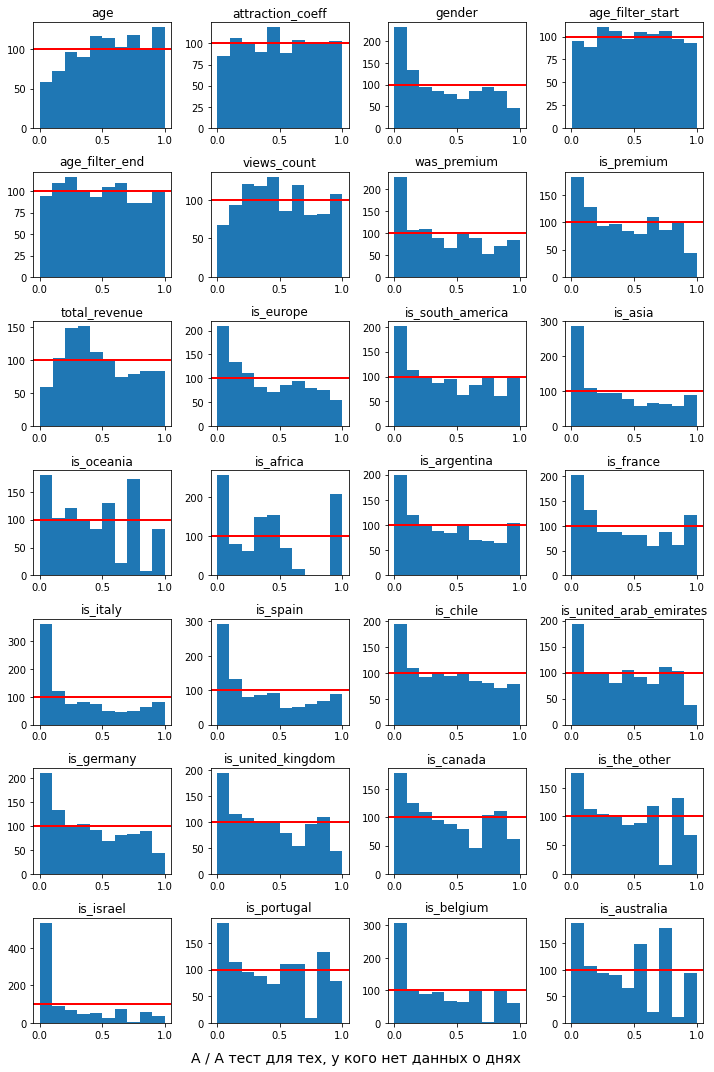

In [32]:
keys = []
for i in range(7):
    for j in range(4):
        keys.append(str(i)+str(j))
interat = {i: keys.index(i) for i in keys}
figure, axis = plt.subplots(7, 4, figsize=(10, 15))
  
for i in range(7):
    for j in range(4):
        x = interat[str(i)+str(j)]
        axis[i, j].hist(pv_t[pv_t.columns[x]], bins = 10)
        axis[i, j].axline((0, 100), (1, 100), linewidth=2, color='r')
        axis[i, j].set_title(pv_t.columns[x])

figure.suptitle('А / А тест для тех, у кого нет данных о днях', y = 0,
             fontsize=14)
figure.tight_layout()
plt.show()

Добавилось и неодинаковое распределение по полу. 

In [33]:
np.random.seed(3)
pv_t = pd.DataFrame(a_a_boot(df_visit_days_1, 'control_1 == 1', 'control_2 == 1'))
pv_t = pv_t.drop(['control_1', 'control_2'], axis = 1)

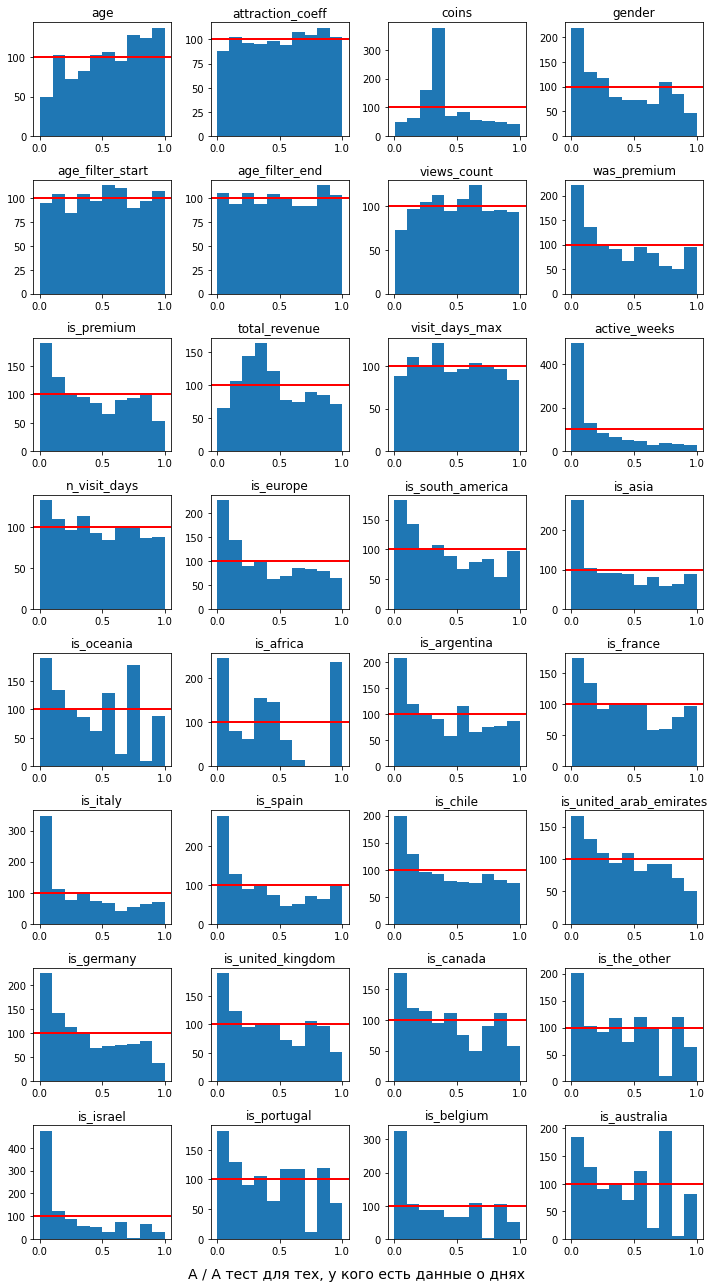

In [34]:
keys = []
for i in range(8):
    for j in range(4):
        keys.append(str(i)+str(j))
interat = {i: keys.index(i) for i in keys}
figure, axis = plt.subplots(8, 4, figsize=(10, 18))
  
for i in range(8):
    for j in range(4):
        x = interat[str(i)+str(j)]
        axis[i, j].hist(pv_t[pv_t.columns[x]], bins = 10)
        axis[i, j].axline((0, 100), (1, 100), linewidth=2, color='r')
        axis[i, j].set_title(pv_t.columns[x])

figure.suptitle('А / А тест для тех, у кого есть данные о днях', y = 0,
             fontsize=14)
figure.tight_layout()
plt.show()

Результаты не отличимы от результатов без отделения наблюдей нулевых 

Отдельные тесты для отдельных датастов с данными о днях не показали ничего нового в плане распределениях характеристик: они все так же смещены. При этом основные характеристики (пол, возраст, привлекательность), а так же интересующая переменная выручка не смещенны. Потому, хоть и не хотя, можно провести А/В тест.

### 3. А/В тест

### Для выручки и монет

In [35]:
df['treatment'] = [0 if x == 1 else 1 for x in (df.control_1 + df.control_2).to_list()]
df = df.drop(['control_1', 'control_2'], axis = 1)

In [36]:
t = df.query('treatment == 1').total_revenue.to_numpy()
c = df.query('treatment == 0').total_revenue.to_numpy()
print(f'Средняя выручка в тестовой группе {round(np.mean(t))} со стандартным отклонением {round(np.std(t))},' + 
      f'{chr(10)}в контрольной группе {round(np.mean(c))} со стандартным отклонением {round(np.std(c))},'+ 
      f' {chr(10)}вероятность равенства средних {round(ss.ttest_ind(t, c).pvalue, 3)}')

Средняя выручка в тестовой группе 534 со стандартным отклонением 4371,
в контрольной группе 523 со стандартным отклонением 6019, 
вероятность равенства средних 0.916


In [37]:
t = df.query('treatment == 1').coins.to_numpy()
c = df.query('treatment == 0').coins.to_numpy()
print(f'Среднее число монет в тестовой группе {round(np.mean(t))} со стандартным отклонением {round(np.std(t))},' + 
      f'{chr(10)}в контрольной группе {round(np.mean(c))} со стандартным отклонением {round(np.std(c))},'+ 
      f' {chr(10)}вероятность равенства средних {round(ss.ttest_ind(t, c).pvalue, 3)}')

Среднее число монет в тестовой группе 3 со стандартным отклонением 130,
в контрольной группе 12 со стандартным отклонением 1078, 
вероятность равенства средних 0.557


### Промежуточный вывод

А/B тест говорит, что нет значимого эффекта от увеличения выручки, а эффект на внутренню валюту пусть и незначимый тоже, даже отрицательный. Остановившись здесь можно сказать, что эффекта от увеличения стоимости подписки нет. Зная, что вообще-то у нас не все гладко с в спилит-системе, можно попробовать попробовать это несколько исправить.

### 4. Propensity Score Matching

Поскольку я не нашел никаких ошибок в данных таких, что их можно было удалить, и даже без тех данных, что казались подозрительным (0 активных дней) проблема смещенности не исчезла, проблема не в ошибках, а в сплит-системе. В целом, чтобы исправить можно попробовать исправить сплит-систему с помощью простого дедовского Propensity Score Matching

### Описание алгоритма

Здесь будет описание деталей мною использованного алгоритма. В остальном это обычный psm.
1. Оценку отнесения переменных к контрольной группе я оценил с помощью двух логит-регрессий на переменную treatment. Первая регрессия включала себя все переменные кроме выручки и странновых переменных, вторая только страновые переменные. Первое соображение что таким образом влияние странновых переменных получается больше, чем если из них не получать отдельный propensity score. Мне показалось это разумным, так как странновые характеристики были самые смешенные в сплит-системе. Второе соображение, что 2d достаточно просто визуально увидеть кластеры.
2. Кластеризацию я проводил с помощью k-means алгоритма, так как все координаты числовые, и он будет хорошо работать. Я понимаю, что это далеко не единственный вариант, но я не вижу, чем он здесь __радикально__ плох.
3. Так как K-means сильно зависят от начальной точки, я, чтобы получить более достоверную оценку, использовал 1000 разных стартовых точек (как выяснилось, не зря).
4. Количество кластеров непринципиально, пробовал разное количество остановился на 20. Такое количество не увеличивало исключение кластеров в которые не попадали либо данные из контрольной группы или из тестовой. (Почему данные исключались ниже)
5. Выбирая между "убирать точки из кластеров, если контрольных и тестовых наблюдений неравное количество" и "добавлять точки до равного количества в контрольной и тестовой группах", я выбрал второе. Добавление точек в кластер смещает его центр и, вообще говоря, меняеет его. Но пересчитывать по несколько раз после добавления -- это несколько too much, особенно если учесть, что алгоритм неустойчивый к начальным центрам кластеров. Соответственно если в кластере нет наблюдений из одной из групп, так кой кластер к сожалению, удалялся из выборки. Количество удаленных наблюденений для каждого старта печатается (вышло так, что постоянно пропадало одно наблюдение, ну ладно, на выборке 12912 нестрашно.
2. Подбирались недостающие для равного количества наблюдения по принципу наименьшего растояния до центра кластера: наблюдения ранжировались, а потом добавлялись. Непосредственно алгоритм можно посмотреть в *#find the ates*, переменная indexes.
6. По-хорошему нужно было для каждой кластеризации смотреть как исправилось смещение и проводить А/А тесты, но...
7. Для упрощения расчетов, чтобы не считать веса для ATE, а потом считать АТЕ, просто новые нужные наблюдения добавлялись в таблицу, а потом проводился просто А/В тест. Это эквивалентно расчету АТЕ, плюс получаем сразу значимость разницы средних между контрольно и тестовой группой, что позволяет прямо сравнить их с ппроведенным ранее А/В тестом.
8. На предыдущем шаге я посчитал разницу в средних для внутренней валюты. Я не могу придумать, не зная контекста, как можно однозначно интерпретировать эту разницу в любую сторону на самом деле, потому переменная coins отправлена в первую регрессию и на по ней не проводилось сравнение средних в PSM.

### Logit propensity scores

Разделим выборку по качественным и странновым переменным, не добавим в качественные выручку, так как это интересующая нас переменная

In [38]:
not_uniform = ['age', 'attraction_coeff', 'coins', 'gender', 'age_filter_start',
               'age_filter_end', 'views_count', 'was_premium', 'is_premium',
               'visit_days_max', 'active_weeks', 'n_visit_days']
not_uniform_c = ['is_europe', 'is_south_america', 'is_asia', 'is_oceania', 'is_africa',
               'is_argentina', 'is_france', 'is_italy', 'is_spain', 'is_chile',
               'is_united_arab_emirates', 'is_germany', 'is_united_kingdom',
               'is_canada', 'is_the_other', 'is_israel', 'is_portugal', 'is_belgium',
               'is_australia']

Найдем вероятностные значения относения в тестовую группу. Так как меня не интересуют коеффициенты при переменных, можно не исправлять ни мультиколлениарность, ни гетероскедастичность.

In [39]:
X_not_uniform = df[not_uniform].to_numpy()
y = df.treatment.to_numpy()
model = LogisticRegression(class_weight='balanced', max_iter = 1000)
model = model.fit(X_not_uniform, y)

Запишим в таблицу значение для качественных переменных

In [40]:
df['propensity_score'] = 1/(1+np.exp(-X_not_uniform.dot(model.coef_[0])))

Тоже самое со странновыми переменными

In [41]:
X_not_uniform_c = df[not_uniform_c].to_numpy()
model = LogisticRegression(class_weight='balanced')
model = model.fit(X_not_uniform_c, y)
df['propensity_score_c'] = 1/(1+np.exp(-X_not_uniform_c.dot(model.coef_[0])))

Вот такой график распределения propensity score.

<AxesSubplot:xlabel='propensity_score_c', ylabel='propensity_score'>

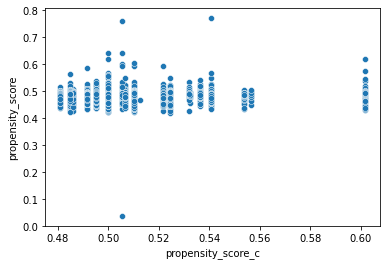

In [42]:
sns.scatterplot(data = df, x = 'propensity_score_c', y = 'propensity_score')

### Matching и выводы об А/В тесте

Алгоритм по нахождению АТЕ и эвклидового расстояния.

In [43]:
def evcl_dist(point0, point1, cluster_n, kmeans):
    return np.sqrt((point0 - kmeans.cluster_centers_[cluster_n][0])**2 + (point1-kmeans.cluster_centers_[cluster_n][1])**2)

In [44]:
def ATE(df, list_of_scores, treatment, random_state_, n_cluster):
    
    #k-means clustering
    X = [[df[list_of_scores[0]][i], df[list_of_scores[1]][i]]  for i in range(df.shape[0])]
    kmeans = cluster.KMeans(n_clusters = n_cluster , random_state = random_state_).fit(X)
    df['groups'] = kmeans.labels_
    
    
    #find the distance
    df['dist'] = [evcl_dist(i0, i1, c, kmeans) for i0, i1, c in zip(df.loc[:,list_of_scores[0]].to_numpy(),
                                                            df.loc[:,list_of_scores[1]].to_numpy(),
                                                            df.loc[:,'groups'].to_numpy())]
    
    
    #find the list of prepaired groups
    list_of_groups = [i in df.query(f'{treatment} == 1').groups.unique() 
                  and i in df.query(f'{treatment} == 1').groups.unique()
                  for i in range(n_cluster)]
    list_of_groups = np.array([i for i in range(n_cluster)])[list_of_groups]
    
    
    #find the differences in groups between control and treatment
    df_temp = df.loc[:,[list_of_scores[0], list_of_scores[0], 'groups', 'dist', 'treatment']]
    
    X0 = df_temp.query(f'{treatment} == 0').groupby(['groups'], as_index = False).agg({'dist':'count'})
    X0 = X0.loc[[i in list_of_groups for i in X0.groups]]
    
    X1 = df_temp.query(f'{treatment} == 1').groupby(['groups'], as_index = False).agg({'dist':'count'})
    X1 = X1.loc[[i in list_of_groups for i in X1.groups]]
    
    addings_array = X0.dist.to_numpy() - X1.dist.to_numpy()
    
    
    #drop unoprepaired groups
    dim0 = df.shape[0]
    df = df.loc[[i in list_of_groups for i in df.groups]]
    dim1 = df.shape[0]
    print(f'Удалено {dim0-dim1} наблюдений при random state = {random_state_}')
    
    
    #find the ates    
    df_psm = df
    for n, i in zip(addings_array, list_of_groups):
        if n > 0: 
            indexes = df.query(f'{treatment} == 1 & groups == {i}').sort_values(by = 'dist').index.to_list()
            
            shp = abs(n) // len(indexes) + 1
            indexes = indexes*shp
            indexes = indexes[:abs(n)]
            
            df_psm = pd.concat([df_psm, df.loc[indexes, :]])
            
        elif n < 0:
            indexes = df.query(f'{treatment} == 0 & groups == {i}').sort_values(by = 'dist').index.to_list()
            
            shp = abs(n) // len(indexes) + 1
            indexes = indexes*shp
            indexes = indexes[:abs(n)]
            
            df_psm = pd.concat([df_psm, df.loc[indexes, :]])

    t = df_psm.query('treatment == 1').total_revenue.to_numpy()
    c = df_psm.query('treatment == 0').total_revenue.to_numpy()
    result = [t.mean(), c.mean(), t.mean() - c.mean(), round(ss.ttest_ind(t, c).pvalue, 5)]
    return result   

К-средние сильно зависят от старта

In [45]:
ATEs = []
for i in range(1000):
    try:
        ATEs.append(ATE(df, ['propensity_score_c', 'propensity_score'], 'treatment', i, 20))
    except:
        print(f'с {i} что-то пошло не так')
        break

Удалено 1 наблюдений при random state = 0
Удалено 1 наблюдений при random state = 1
Удалено 1 наблюдений при random state = 2
Удалено 1 наблюдений при random state = 3
Удалено 1 наблюдений при random state = 4
Удалено 1 наблюдений при random state = 5
Удалено 1 наблюдений при random state = 6
Удалено 1 наблюдений при random state = 7
Удалено 1 наблюдений при random state = 8
Удалено 1 наблюдений при random state = 9
Удалено 1 наблюдений при random state = 10
Удалено 1 наблюдений при random state = 11
Удалено 1 наблюдений при random state = 12
Удалено 1 наблюдений при random state = 13
Удалено 1 наблюдений при random state = 14
Удалено 1 наблюдений при random state = 15
Удалено 1 наблюдений при random state = 16
Удалено 1 наблюдений при random state = 17
Удалено 1 наблюдений при random state = 18
Удалено 1 наблюдений при random state = 19
Удалено 1 наблюдений при random state = 20
Удалено 1 наблюдений при random state = 21
Удалено 1 наблюдений при random state = 22
Удалено 1 наблюдений 

Удалено 1 наблюдений при random state = 189
Удалено 1 наблюдений при random state = 190
Удалено 1 наблюдений при random state = 191
Удалено 1 наблюдений при random state = 192
Удалено 1 наблюдений при random state = 193
Удалено 1 наблюдений при random state = 194
Удалено 1 наблюдений при random state = 195
Удалено 1 наблюдений при random state = 196
Удалено 1 наблюдений при random state = 197
Удалено 1 наблюдений при random state = 198
Удалено 1 наблюдений при random state = 199
Удалено 1 наблюдений при random state = 200
Удалено 1 наблюдений при random state = 201
Удалено 1 наблюдений при random state = 202
Удалено 1 наблюдений при random state = 203
Удалено 1 наблюдений при random state = 204
Удалено 1 наблюдений при random state = 205
Удалено 1 наблюдений при random state = 206
Удалено 1 наблюдений при random state = 207
Удалено 1 наблюдений при random state = 208
Удалено 1 наблюдений при random state = 209
Удалено 1 наблюдений при random state = 210
Удалено 1 наблюдений при random 

Удалено 1 наблюдений при random state = 376
Удалено 1 наблюдений при random state = 377
Удалено 1 наблюдений при random state = 378
Удалено 1 наблюдений при random state = 379
Удалено 1 наблюдений при random state = 380
Удалено 1 наблюдений при random state = 381
Удалено 1 наблюдений при random state = 382
Удалено 1 наблюдений при random state = 383
Удалено 1 наблюдений при random state = 384
Удалено 1 наблюдений при random state = 385
Удалено 1 наблюдений при random state = 386
Удалено 1 наблюдений при random state = 387
Удалено 1 наблюдений при random state = 388
Удалено 1 наблюдений при random state = 389
Удалено 1 наблюдений при random state = 390
Удалено 1 наблюдений при random state = 391
Удалено 1 наблюдений при random state = 392
Удалено 1 наблюдений при random state = 393
Удалено 1 наблюдений при random state = 394
Удалено 1 наблюдений при random state = 395
Удалено 1 наблюдений при random state = 396
Удалено 1 наблюдений при random state = 397
Удалено 1 наблюдений при random 

Удалено 1 наблюдений при random state = 563
Удалено 1 наблюдений при random state = 564
Удалено 1 наблюдений при random state = 565
Удалено 1 наблюдений при random state = 566
Удалено 1 наблюдений при random state = 567
Удалено 1 наблюдений при random state = 568
Удалено 1 наблюдений при random state = 569
Удалено 1 наблюдений при random state = 570
Удалено 1 наблюдений при random state = 571
Удалено 1 наблюдений при random state = 572
Удалено 1 наблюдений при random state = 573
Удалено 1 наблюдений при random state = 574
Удалено 1 наблюдений при random state = 575
Удалено 1 наблюдений при random state = 576
Удалено 1 наблюдений при random state = 577
Удалено 1 наблюдений при random state = 578
Удалено 1 наблюдений при random state = 579
Удалено 1 наблюдений при random state = 580
Удалено 1 наблюдений при random state = 581
Удалено 1 наблюдений при random state = 582
Удалено 1 наблюдений при random state = 583
Удалено 1 наблюдений при random state = 584
Удалено 1 наблюдений при random 

Удалено 1 наблюдений при random state = 750
Удалено 1 наблюдений при random state = 751
Удалено 1 наблюдений при random state = 752
Удалено 1 наблюдений при random state = 753
Удалено 1 наблюдений при random state = 754
Удалено 1 наблюдений при random state = 755
Удалено 1 наблюдений при random state = 756
Удалено 1 наблюдений при random state = 757
Удалено 1 наблюдений при random state = 758
Удалено 1 наблюдений при random state = 759
Удалено 1 наблюдений при random state = 760
Удалено 1 наблюдений при random state = 761
Удалено 1 наблюдений при random state = 762
Удалено 1 наблюдений при random state = 763
Удалено 1 наблюдений при random state = 764
Удалено 1 наблюдений при random state = 765
Удалено 1 наблюдений при random state = 766
Удалено 1 наблюдений при random state = 767
Удалено 1 наблюдений при random state = 768
Удалено 1 наблюдений при random state = 769
Удалено 1 наблюдений при random state = 770
Удалено 1 наблюдений при random state = 771
Удалено 1 наблюдений при random 

Удалено 1 наблюдений при random state = 937
Удалено 1 наблюдений при random state = 938
Удалено 1 наблюдений при random state = 939
Удалено 1 наблюдений при random state = 940
Удалено 1 наблюдений при random state = 941
Удалено 1 наблюдений при random state = 942
Удалено 1 наблюдений при random state = 943
Удалено 1 наблюдений при random state = 944
Удалено 1 наблюдений при random state = 945
Удалено 1 наблюдений при random state = 946
Удалено 1 наблюдений при random state = 947
Удалено 1 наблюдений при random state = 948
Удалено 1 наблюдений при random state = 949
Удалено 1 наблюдений при random state = 950
Удалено 1 наблюдений при random state = 951
Удалено 1 наблюдений при random state = 952
Удалено 1 наблюдений при random state = 953
Удалено 1 наблюдений при random state = 954
Удалено 1 наблюдений при random state = 955
Удалено 1 наблюдений при random state = 956
Удалено 1 наблюдений при random state = 957
Удалено 1 наблюдений при random state = 958
Удалено 1 наблюдений при random 

Посмотрим на распределение разницы средних и вероятности их равенства:

<AxesSubplot:ylabel='Count'>

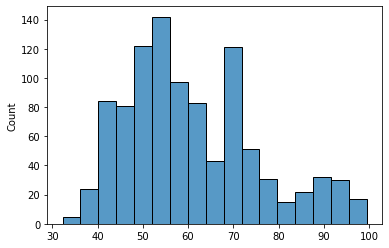

In [46]:
sns.histplot(x = np.array([ATEs[i][2] for i in range(1000)]))

<AxesSubplot:ylabel='Count'>

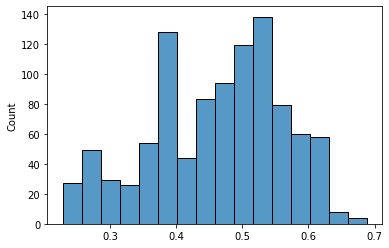

In [47]:
sns.histplot(x = np.array([ATEs[i][3] for i in range(1000)]))

Видно, что разница средних стала больше: средняя выручка с исправлениями выросла больше, но значимости все так же нет. Вывод: эксперемент нужно признать неуспешным все таки.
Все таки сплит система была сломана несильно, потому и после исправления результат несильно поменялся.

### 5. Регрессионный анализ влияния отдельных переменных

Для того, чтобы оценить влияние отдельных факторов займемся регрессионным анализом.

Поменяем данные немного о начале и конце возрастного фильтра, чтобы они не зависили от возраста напрямую совсем. Понятно, что зависимость останется, и границы связанны с возрастом (40-летний/яя может поставить на 20 лет младше границу, а 20-летний/яя не может, на пример).

In [48]:
df['age_filter_start'] = df.age_filter_start - df.age
df['age_filter_end'] = df.age_filter_end - df.age

В лоб.

In [49]:
df['const'] = [1]*df.shape[0] # так по дефолту костанты нет
x = df.drop(['total_revenue'], axis = 1)
y = df['total_revenue']

In [50]:
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          total_revenue   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     96.73
Date:                Thu, 22 Dec 2022   Prob (F-statistic):               0.00
Time:                        20:46:16   Log-Likelihood:            -1.2808e+05
No. Observations:               12912   AIC:                         2.562e+05
Df Residuals:                   12876   BIC:                         2.565e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
age                     -1

Большинство коеффициентов незначимы, а странновые так вообще все.
Так как странновые, скорее всего, связаны между ссобой, проблема может быть связанна с мультиколлиарностью. Посмотри сколько потеряем объясненной дисперсии если исключим эти переменные.

In [51]:
x = df.drop(['total_revenue','is_europe', 'is_south_america', 'is_asia', 'is_oceania', 'is_africa',
               'is_argentina', 'is_france', 'is_italy', 'is_spain', 'is_chile',
               'is_united_arab_emirates', 'is_germany', 'is_united_kingdom',
               'is_canada', 'is_the_other', 'is_israel', 'is_portugal', 'is_belgium','is_australia'], axis = 1)
y = df['total_revenue']
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          total_revenue   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     197.8
Date:                Thu, 22 Dec 2022   Prob (F-statistic):               0.00
Time:                        20:46:18   Log-Likelihood:            -1.2809e+05
No. Observations:               12912   AIC:                         2.562e+05
Df Residuals:                   12894   BIC:                         2.563e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
age                -1771.7990     76

Исправленный р-квадрат не изменился, можно с чистой совестью отбросить эти переменные. Пока по крайней мере. 
Посмотрим есть ли гетероскедастичность. Проведем сначала тест Уайта на ее наличие.

In [59]:
sm.stats.diagnostic.het_white(results.resid, x)

AssertionError: 

In [60]:
import patsy
patsy.__version__

'0.5.2'

In [54]:
print(f'Гетероскедастичности нет с вероятностью {sm.stats.diagnostic.het_white(results.resid, x)[3]} %')

AssertionError: 

In [ ]:
print(f'Распределение ошибок нормально с вероятностью {ss.normaltest(results.resid)[1]} %')

In [192]:
print(f'Гетероскедастичность зависит от линейного наборапеременных с вероятностью {sm.stats.diagnostic.het_white(results.resid, x)[3]} %')

Гетероскедастичность зависит от линейного наборапеременных с вероятностью 0.0 %


Возьмем доступный ОМНК

In [61]:
sigma = (results.resid - results.resid.mean())**2

In [62]:
model = sm.regression.linear_model.GLS(y, x, sigma)
results = model.fit()
print(results.summary())

                            GLS Regression Results                            
Dep. Variable:          total_revenue   R-squared:                       0.998
Model:                            GLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 3.796e+05
Date:                Thu, 22 Dec 2022   Prob (F-statistic):               0.00
Time:                        20:56:10   Log-Likelihood:                -82975.
No. Observations:               12912   AIC:                         1.660e+05
Df Residuals:                   12894   BIC:                         1.661e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
age                 -632.3162     10

In [64]:
print(f'Гетероскедастичности нет с вероятностью {sm.stats.diagnostic.het_white(results.resid, x)[3]} %')

AssertionError: 

Она все равно есть, и с ней доверительные интервалы оценок не получаются несмещенными, но хоть сами оценки коэффициентов получаются несмещенными, можно хоть направление влияния указать.

### Общие выводы
1. Увеличение подписки не произвело значимого увеличения выручки.
2. Ни одни из страновых переменных не оказались значимыми 
3. Чем больше привлекательность, чем больше лет, чем дольше дней пользователь использует в приложение, тем меньше выручка от него. Если для привлекательности более-менее интуитвно понятно (они не нуждаются в дополнительных фичах для того, чтобы найти пару), то для второе и третье несколько удивительно.
4. Количество дней, проведенных в приложении, пол (тот что обозначен 1, скорее всего это мужчины), предыдущий опыт подписки положительно связаны с выручкой от пользователя. Здесь достаточно интуитивно понятно.

Коментарий: нужно разобраться с гетероскедастичностью, чтобы получить оценки, по которым можно будет будет написать насколько переменные влияют на выручку. Самым удивительным результатом считаю незначимость странновых переменных: вроде как страны достаточно разные, с разной культурой и средним доходом, потому должна быть какая-то зависимость между выручкой и странами.